# archaeological data from central part of Moravia (the Czech republic)

## data collection, cleaning and processing data that were used for the model used in the app [cultural classifier](https://cultural-classifier.herokuapp.com/) and the scientific [paper](https://www.sciencedirect.com/science/article/abs/pii/S1040618220303657) 

In [1]:
%matplotlib inline 
import re
import pandas as pd
import numpy as np
import scipy as sp
import random 
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style("whitegrid")
#sns.set_context("poster")
#from mpl_toolkits.mplot3d import Axes3D

<div style="background-color: red; height:50px; width: 100%; display: inline-block; text-align:center;">
<h1>Data collection and basic exploratory analysis </h1>
</div>

In [2]:
dataset = pd.read_excel("C:/Users/hamro/Desktop/finished_projects/arch-heroku/data_used_for_training_model/arch_sites.xlsx")
df = dataset.copy()

### available data

In [3]:
df.head()

,No,site,X,Y,LU zone,LU Min,LU Max,LU Range,Terrain variability 500 m buffer,Terrain variability 1000 m buffer,...,Related River,Unnamed: 28,DtR (m)cor,DtR (d2),EAR2+DtR2,DrRslope (m) cumulative distance,orientation,Orientation (azimut),Viewhed,source
0,1,Alojzov I - Golštýn,-562964.93,-1138227.15,MHana_N,178,744,566,65,136,...,Morava,NaN,17400,302760000,302783716,17400.681481,NE,45,197464,Oliva 1987
1,2,Blažovice I,-585774.40,-1167261.00,Litava_N,169,587,418,23,43,...,Litava,NaN,3200,10240000,10256384,3202.558977,top,top,148319,Oliva 1987-PV
2,3,Bratčice,-604795.00,-1175455.00,Svratka_S,165,468,303,28,42,...,Svratka,NaN,5430,29484900,29488149,5430.299163,N,0,22734,Valoch 1974; Nerudová in press
3,4,Brno - Jundrov,-602166.00,-1157987.00,Svratka_N,190,487,297,48,127,...,Svratka,NaN,270,72900,75109,274.060212,SE,135,1834,Oliva 1991
4,5,Brno - Kohoutovice I,-603480.00,-1161080.00,Svratka_N,190,487,297,55,127,...,Svratka,NaN,2300,5290000,5330000,2308.679276,top,top,204292,Oliva 1987


In [4]:
df.shape

(48, 37)

In [5]:
df.dtypes

No                                                                                                                                                                                                                                                      int64
site                                                                                                                                                                                                                                                   object
X                                                                                                                                                                                                                                                     float64
Y                                                                                                                                                                                                                                             

In [6]:
df.info

<bound method DataFrame.info of     No                                               site          X  \
0    1                                Alojzov I - Golštýn -562964.93   
1    2                                        Blažovice I -585774.40   
2    3                                           Bratčice -604795.00   
3    4                                     Brno - Jundrov -602166.00   
4    5                               Brno - Kohoutovice I -603480.00   
5    6                           Brno - Stránská skála IV -593250.00   
6    7                                 Brno - Štýřice III -599244.00   
7    8                            Brno -Štýřice, Hospital -599090.00   
8    9                        Brno - Štýřice, Kamenná St. -599258.00   
9   10                          Brno - Štýřice, Polní St. -599174.00   
10  11                Brno - Štýřice, Vídeňská St 849/15  -599202.00   
11  12                                 Dolní Otaslavice I -563232.97   
12  13           Drahanovice - n

In [21]:
df.duplicated().sum()

0

<div style="background-color: yellow; height:50px; width: 100%; display: inline-block; text-align:center;">
<h1>data wrangling</h1>
</div>

##### classification if eau/epig denote as neutral (ambiguous)
##### Viewshed - how many pixels are visible from a given point on the map (so it's related to altitude)
##### Relative hight in LUmin (%), related to elevation above river
##### most important attributes - elevation above river, terrain variability and how far from a river (DtR (m)cor )
##### a few sites situated on the hilltop e.g.  (brno-kohoutovice)

In [7]:
preprocess_df = df.drop(['No','X','Y','Unnamed: 28','Unnamed: 26','DrRslope (m) cumulative distance', 'Blanks (n)','Počet použitých surovin','source','finds','stratigraphy','Related River','AUG content','Elevation above river (h2)','Altitude average','Velikost a typ lokality','Orientation (azimut)'],axis = 1)
# we dropped a column with index 11
preprocess_df = preprocess_df.drop(preprocess_df.columns[11], axis=1)
preprocess_df.head()

,site,LU zone,LU Min,LU Max,LU Range,Terrain variability 500 m buffer,Terrain variability 1000 m buffer,Classsific.,Lithics (N),Cores (N),Tools (N),Altitude a.s.l.,Elevation above river (m),Relative hight in LUmin (%),DtR (m)cor,DtR (d2),EAR2+DtR2,orientation,Viewhed
0,Alojzov I - Golštýn,MHana_N,178,744,566,65,136,EAU,8015,305.0,1879,323-341,154,27.208481,17400,302760000,302783716,NE,197464
1,Blažovice I,Litava_N,169,587,418,23,43,EAU/EPIG,75,6.0,15,297,128,30.622010,3200,10240000,10256384,top,148319
2,Bratčice,Svratka_S,165,468,303,28,42,EPIG,8,0.0,0,NaN,57,18.811881,5430,29484900,29488149,N,22734
3,Brno - Jundrov,Svratka_N,190,487,297,48,127,EAU/EPIG,335,14.0,60,235-240,47,15.824916,270,72900,75109,SE,1834
4,Brno - Kohoutovice I,Svratka_N,190,487,297,55,127,EAU,915,43.0,200,390,200,67.340067,2300,5290000,5330000,top,204292


In [8]:
preprocess_df.isnull().sum()

site                                 0
LU zone                              0
LU Min                               0
LU Max                               0
LU Range                             0
Terrain variability 500 m buffer     0
Terrain variability 1000 m buffer    0
Classsific.                          0
Lithics (N)                          5
Cores (N)                            8
Tools (N)                            8
Altitude a.s.l.                      1
Elevation above river (m)            0
Relative hight in LUmin (%)          0
DtR (m)cor                           0
DtR (d2)                             0
EAR2+DtR2                            0
orientation                          0
Viewhed                              0
dtype: int64

In [9]:
preprocess_df.rename(columns = {"Viewhed":"Viewshed"}, inplace = True)
preprocess_df.rename(columns = {"Classsific.":"Classific"}, inplace = True)
preprocess_df

,site,LU zone,LU Min,LU Max,LU Range,Terrain variability 500 m buffer,Terrain variability 1000 m buffer,Classific,Lithics (N),Cores (N),Tools (N),Altitude a.s.l.,Elevation above river (m),Relative hight in LUmin (%),DtR (m)cor,DtR (d2),EAR2+DtR2,orientation,Viewshed
0,Alojzov I - Golštýn,MHana_N,178,744,566,65,136,EAU,8015,305.0,1879,323-341,154,27.208481,17400,302760000,302783716,NE,197464
1,Blažovice I,Litava_N,169,587,418,23,43,EAU/EPIG,75,6.0,15,297,128,30.622010,3200,10240000,10256384,top,148319
2,Bratčice,Svratka_S,165,468,303,28,42,EPIG,8,0.0,0,NaN,57,18.811881,5430,29484900,29488149,N,22734
3,Brno - Jundrov,Svratka_N,190,487,297,48,127,EAU/EPIG,335,14.0,60,235-240,47,15.824916,270,72900,75109,SE,1834
4,Brno - Kohoutovice I,Svratka_N,190,487,297,55,127,EAU,915,43.0,200,390,200,67.340067,2300,5290000,5330000,top,204292
5,Brno - Stránská skála IV,Svitava E,183,472,289,48,70,EAU/EPIG,144,11.0,21,254,71,24.567474,3430,11764900,11769941,N,114620
6,Brno - Štýřice III,Svratka_N,190,487,297,31,68,EPIG,9149,124.0,248,220,30,10.101010,250,62500,63400,NE,7675
7,"Brno -Štýřice, Hospital",Svratka_N,190,487,297,21,72,EPIG,25,1.0,4,209,15,5.050505,80,6400,6625,E,2460
8,"Brno - Štýřice, Kamenná St.",Svratka_N,190,487,297,28,72,EPIG,140,4.0,16,210,20,6.734007,140,19600,20000,floodplain,5558
9,"Brno - Štýřice, Polní St.",Svratka_N,190,487,297,26,68,EPIG,1,0.0,0,210,20,6.734007,160,25600,26000,E,6692


In [10]:
preprocess_df['Classific'].value_counts()


EPIG        26
EAU         15
EAU/EPIG     4
?            2
SZ/EAU       1
Name: Classific, dtype: int64

In [11]:
preprocess_df['orientation'].unique()

array(['NE', 'top', 'N', 'SE', 'E', 'floodplain', 'SW', 'W', 'S', 'NW'],
      dtype=object)

In [12]:
replaced_column = preprocess_df['Classific']
replaced_column = replaced_column.replace({'EAU/EPIG': 'AMB','\?':'AMB','SZ/EAU':'AMB'}, regex=True)

# we're replacing all values in the Classific column
for i in range(len(preprocess_df['Classific'])):
    preprocess_df['Classific'].iloc[i] = replaced_column[i]
preprocess_df['Classific'].head()

C:\Users\hamro\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0     EAU
1     AMB
2    EPIG
3     AMB
4     EAU
Name: Classific, dtype: object

#### we' re adding additional value at the index 2

In [13]:
from copy import deepcopy

print(preprocess_df['Altitude a.s.l.'].dtypes)
preprocess_df['Altitude a.s.l.'].head()
preprocess_df['Altitude a.s.l.'].iloc[2] = 220
preprocess_df['Altitude a.s.l.']

changed_table = deepcopy(preprocess_df)
changed_table['Altitude a.s.l.']

object


0     323-341
1         297
2         220
3     235-240
4         390
5         254
6         220
7         209
8         210
9         210
10        210
11    298-306
12        310
13        267
14    282-290
15        205
16        316
17    230-235
18        330
19        295
20        297
21    320-360
22    307-321
23        263
24        270
25        260
26        220
27        500
28    180-190
29        321
30        370
31        330
32    225-265
33        330
34    300-340
35        401
36        316
37        464
38    280-310
39        460
40        390
41    250-270
42    320-338
43    290-298
44        257
45        185
46    370-385
47        225
Name: Altitude a.s.l., dtype: object

#### we have to get rid of these interval values and replace Nan value e.g. as average values of sites situated around the closest river

### replacing nan value in Altitude a.s.l. column with average of Altitude of areas situated nearby svratka river 

In [14]:
import math

changed_table['Altitude a.s.l.'] = changed_table['Altitude a.s.l.'].astype(str)
#for item in changed_table['Altitude a.s.l.']: 
pattern = '-' 
regex = re.compile(pattern)
new_column = changed_table['Altitude a.s.l.'].apply(lambda x: regex.split(x))

new_column_correct = []
for i in new_column:
    sum_x = 0
    if len(i) == 2:
        for j in i:
            j = int(j)
            sum_x += j
        new_column_correct.append(math.ceil(sum_x/2))
    else:
        i = int(*i)
        new_column_correct.append(i)

new_column_correct[:5]


[332, 297, 220, 238, 390]

### now we have to replaced all interval values

In [15]:
for i in range(len(preprocess_df['Altitude a.s.l.'])):
    preprocess_df['Altitude a.s.l.'].iloc[i] = new_column_correct[i]
preprocess_df['Altitude a.s.l.'].head()


0    332
1    297
2    220
3    238
4    390
Name: Altitude a.s.l., dtype: object

#### create new column for relative hight in Lumin


In [16]:
preprocess_df_1 = preprocess_df
preprocess_df_1['Normalized height in Lu Min'] = preprocess_df_1['Relative hight in LUmin (%)']/100
preprocess_df_1

,site,LU zone,LU Min,LU Max,LU Range,Terrain variability 500 m buffer,Terrain variability 1000 m buffer,Classific,Lithics (N),Cores (N),Tools (N),Altitude a.s.l.,Elevation above river (m),Relative hight in LUmin (%),DtR (m)cor,DtR (d2),EAR2+DtR2,orientation,Viewshed,Normalized height in Lu Min
0,Alojzov I - Golštýn,MHana_N,178,744,566,65,136,EAU,8015,305.0,1879,332,154,27.208481,17400,302760000,302783716,NE,197464,0.272085
1,Blažovice I,Litava_N,169,587,418,23,43,AMB,75,6.0,15,297,128,30.622010,3200,10240000,10256384,top,148319,0.306220
2,Bratčice,Svratka_S,165,468,303,28,42,EPIG,8,0.0,0,220,57,18.811881,5430,29484900,29488149,N,22734,0.188119
3,Brno - Jundrov,Svratka_N,190,487,297,48,127,AMB,335,14.0,60,238,47,15.824916,270,72900,75109,SE,1834,0.158249
4,Brno - Kohoutovice I,Svratka_N,190,487,297,55,127,EAU,915,43.0,200,390,200,67.340067,2300,5290000,5330000,top,204292,0.673401
5,Brno - Stránská skála IV,Svitava E,183,472,289,48,70,AMB,144,11.0,21,254,71,24.567474,3430,11764900,11769941,N,114620,0.245675
6,Brno - Štýřice III,Svratka_N,190,487,297,31,68,EPIG,9149,124.0,248,220,30,10.101010,250,62500,63400,NE,7675,0.101010
7,"Brno -Štýřice, Hospital",Svratka_N,190,487,297,21,72,EPIG,25,1.0,4,209,15,5.050505,80,6400,6625,E,2460,0.050505
8,"Brno - Štýřice, Kamenná St.",Svratka_N,190,487,297,28,72,EPIG,140,4.0,16,210,20,6.734007,140,19600,20000,floodplain,5558,0.067340
9,"Brno - Štýřice, Polní St.",Svratka_N,190,487,297,26,68,EPIG,1,0.0,0,210,20,6.734007,160,25600,26000,E,6692,0.067340


In [17]:
preprocess_df_1.isnull().sum()

site                                 0
LU zone                              0
LU Min                               0
LU Max                               0
LU Range                             0
Terrain variability 500 m buffer     0
Terrain variability 1000 m buffer    0
Classific                            0
Lithics (N)                          5
Cores (N)                            8
Tools (N)                            8
Altitude a.s.l.                      0
Elevation above river (m)            0
Relative hight in LUmin (%)          0
DtR (m)cor                           0
DtR (d2)                             0
EAR2+DtR2                            0
orientation                          0
Viewshed                             0
Normalized height in Lu Min          0
dtype: int64

### impute values for Lithics and Cores and Tool - using just avarage

In [18]:
# first clean up lithics
# multiple data types in lithics (N) and tools
lithics = [i for i in preprocess_df_1['Lithics (N)'] if type(i) == int]
tools = [i for i in preprocess_df_1['Tools (N)'] if type(i) == int]
mean_num_lithics = sum(lithics)//len(lithics)
mean_num_tools = sum(tools)//len(tools)
mean_num_cores = preprocess_df_1['Cores (N)'].mean()
# replacing empty values
preprocess_df_1['Lithics (N)'] = pd.to_numeric(preprocess_df_1['Lithics (N)'].astype(str).str.replace(',',''), errors='coerce') .fillna(mean_num_lithics).astype(int)
preprocess_df_1['Tools (N)'] = pd.to_numeric(preprocess_df_1['Tools (N)'].astype(str).str.replace(',',''), errors='coerce') .fillna(mean_num_tools).astype(int)
preprocess_df_1['Cores (N)'] = pd.to_numeric(preprocess_df_1['Cores (N)'].astype(str).str.replace(',',''), errors='coerce') .fillna(mean_num_cores).astype(int)

In [19]:
print(f"number empty cells in this dataset is: {sum(preprocess_df_1.isnull().sum())}")

number empty cells in this dataset is: 0


In [20]:
preprocessed_file = preprocess_df_1.copy()

### saving preprocessed file to csv

In [21]:
# saving file to csv
preprocessed_file.to_csv("preprocessed_file_all_attributes_and_records.csv",index=False)

<div style="background-color: blue; height:50px; width: 100%; display: inline-block; text-align:center;">
<h1>data exploration (visualization and grouping)</h1>
</div>

In [22]:
eau = preprocess_df_1[preprocess_df_1['Classific'] == 'EAU']
epig = preprocess_df_1[preprocess_df_1['Classific'] == 'EPIG']
amb = preprocess_df_1[preprocess_df_1['Classific'] == 'AMB']

In [23]:
std_eau = eau['Elevation above river (m)'].std()
mean_eau = eau['Elevation above river (m)'].mean()
std_epig = epig['Elevation above river (m)'].std()
mean_epig =epig['Elevation above river (m)'].mean()
std_amb = amb['Elevation above river (m)'].std()
mean_amb =amb['Elevation above river (m)'].mean()
print(f"mean_eau: {mean_eau}")
print(f"std_eau: {round(std_eau,2)}")
print(f"mean_epig: {round(mean_epig,2)}")
print(f"std_epig: {round(std_epig,2)}")
print(f"mean_amb: {round(mean_amb,2)}")
print(f"std_amb: {round(std_amb,2)}")

mean_eau: 139.0
std_eau: 45.15
mean_epig: 67.62
std_epig: 58.38
mean_amb: 149.57
std_amb: 73.2


### KDE plot for EAU and EPIG related to elevation above sea level

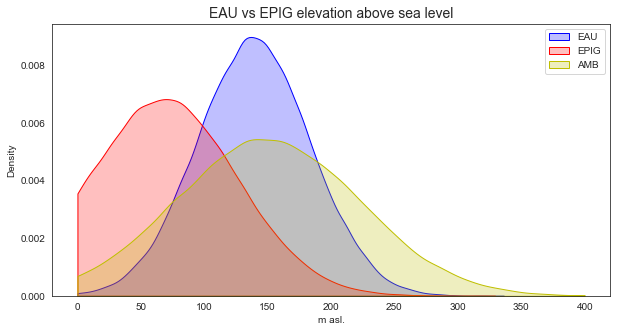

In [24]:
sns.set_style("white")
number_of_trials = 100000
epig_distribution = np.random.normal(mean_epig, std_epig, size= number_of_trials)
eau_distribution = np.random.normal(mean_eau, std_eau, size= number_of_trials)
amb_distribution = np.random.normal(mean_amb, std_amb, size= number_of_trials)

plt.figure(figsize = (10,5))
plt.title("EAU vs EPIG elevation above sea level", fontsize = 14)
sns.kdeplot(eau_distribution, shade=True, color="b", clip = (0, 400), label='EAU')
sns.kdeplot(epig_distribution, shade=True, color="r", clip = (0, 400), label="EPIG")
sns.kdeplot(amb_distribution, shade=True, color="y", clip = (0, 400), label="AMB")
plt.legend(loc='upper right')
plt.xlabel("m asl.")
plt.show()


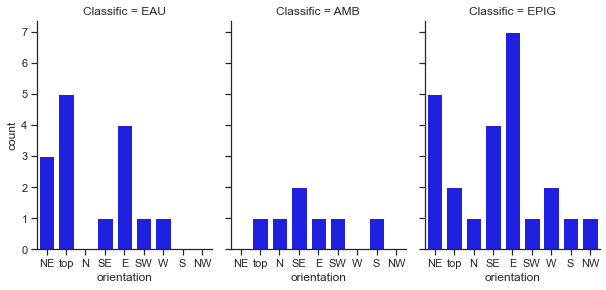

In [25]:
# i have to get rid of floodplain orientation because is misleading and insignificant
%matplotlib inline 
df_orientation = preprocess_df.loc[preprocess_df['orientation'].apply(lambda x: x!= 'floodplain')]
sns.set(style="ticks")
g = sns.catplot(x="orientation", col="Classific",
                data=df_orientation, kind="count",
                height=4, aspect=.7, color = "blue");



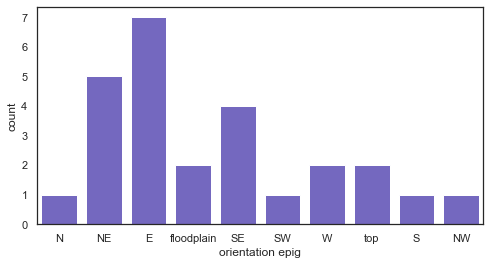

In [26]:
%matplotlib inline 
import seaborn as sns


sns.set(style="white")
sns.set_context({"figure.figsize": (8, 4)})
ax = sns.countplot(x="orientation", data=epig, color = "slateblue")
plt.xlabel("orientation epig")
plt.show()
#plt.savefig("C:/neruda_viz/cardinal_direction_blue_total.pdf")

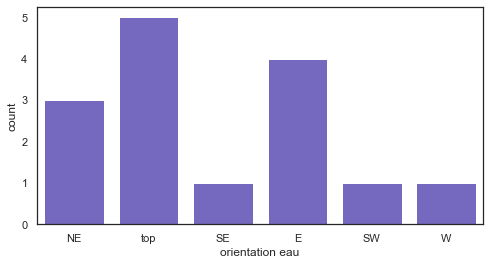

In [27]:
%matplotlib inline
import seaborn as sns
sns.set(style="white")
sns.set_context({"figure.figsize": (8, 4)})
ax = sns.countplot(x="orientation", data=eau, color = "slateblue")
plt.xlabel("orientation eau")
plt.show()

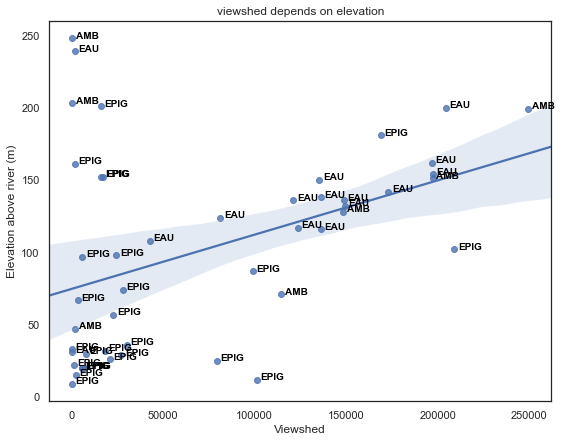

In [30]:
sns.set(style="white")
fig= plt.figure(figsize=(9,7)) 
# confidence interval 95 percent
p1 = sns.regplot(x='Viewshed', y='Elevation above river (m)',  ci=95, truncate=False, fit_reg = True,
            data=preprocess_df)
plt.title("viewshed depends on elevation")
#annotations one by one with a loop
for line in range(0,preprocess_df.shape[0]):
     p1.text(preprocess_df['Viewshed'].iloc[line] + 2000, preprocess_df['Elevation above river (m)'].iloc[line], preprocess_df['Classific'].iloc[line],horizontalalignment='left', size='small', color='black', weight='semibold')


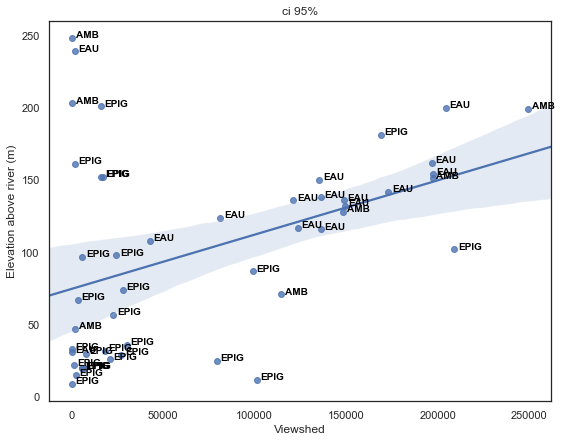

In [31]:
sns.set(style="white")
#sns.set_context("poster")

fig= plt.figure(figsize=(9,7)) 
# confidence interval 95 percent
p1 = sns.regplot(x='Viewshed', y='Elevation above river (m)',  ci=95, truncate=False, fit_reg = True,
            data=preprocess_df)
plt.title("ci 95%")
# add annotations one by one with a loop
for line in range(0,preprocess_df.shape[0]):
     p1.text(preprocess_df['Viewshed'].iloc[line] + 2000, preprocess_df['Elevation above river (m)'].iloc[line], preprocess_df['Classific'].iloc[line],horizontalalignment='left', size='small', color='black', weight='semibold')
        
#fig.savefig("C:/neruda_viz/reg_ci_another95.pdf")

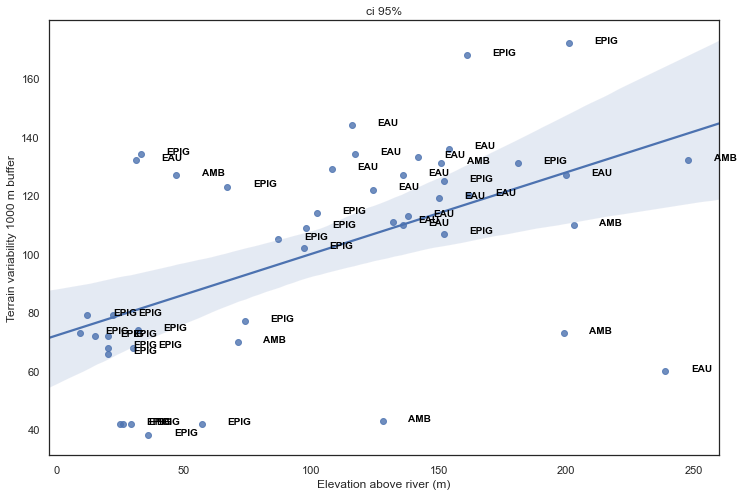

In [33]:
sns.set(style="white")

fig= plt.figure(figsize=(12,8)) 
# confidence interval 95 percent
p1 = sns.regplot(x='Elevation above river (m)', y='Terrain variability 1000 m buffer',  ci=95, truncate=False,
            data=preprocess_df)
plt.title("ci 95%")
# add annotations one by one with a loop
for line in range(0,preprocess_df.shape[0]):
     p1.text(preprocess_df['Elevation above river (m)'].iloc[line] + 10, preprocess_df['Terrain variability 1000 m buffer'].iloc[line], preprocess_df['Classific'].iloc[line],horizontalalignment='left', size='small', color='black', weight='semibold')

[]

<Figure size 864x576 with 0 Axes>

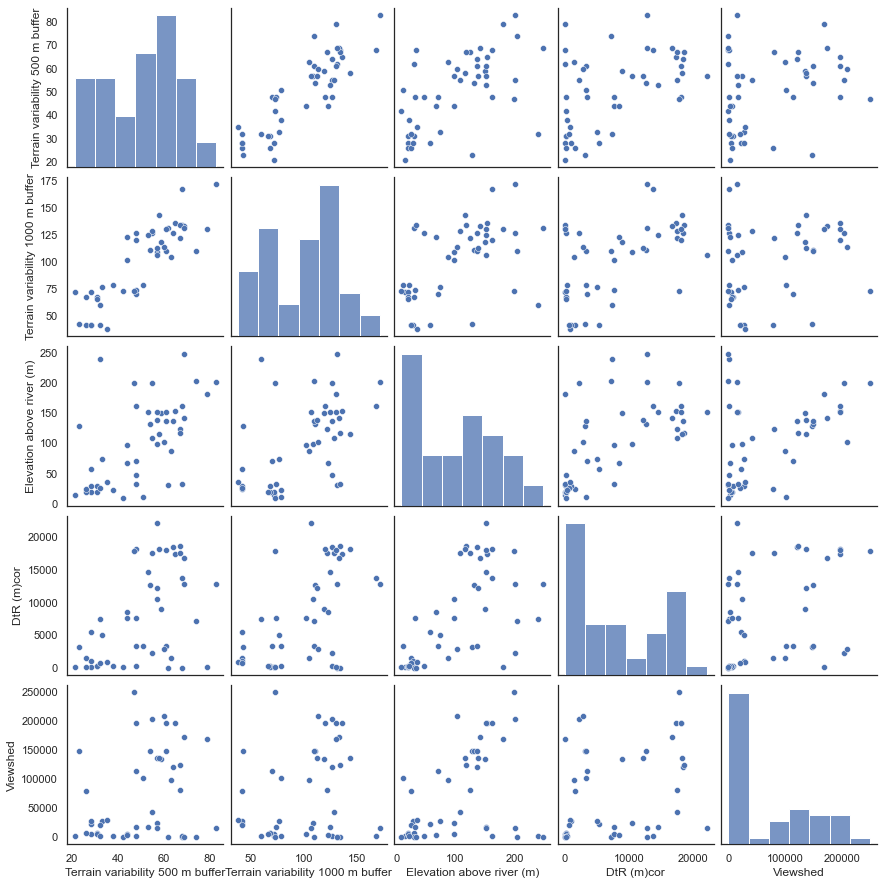

In [51]:
fig = plt.figure(figsize= (12,8))
sns.pairplot(preprocess_df[['Terrain variability 500 m buffer', 'Terrain variability 1000 m buffer','Altitude a.s.l.',
       'Elevation above river (m)',
       'DtR (m)cor','Viewshed']])
#fig.savefig("C:/neruda_viz/pairplot.pdf")
plt.plot()

In [34]:
preprocess_df.columns

Index(['site', 'LU zone', 'LU Min', 'LU Max', 'LU Range',
       'Terrain variability 500 m buffer', 'Terrain variability 1000 m buffer',
       'Classific', 'Lithics (N)', 'Cores (N)', 'Tools (N)', 'Altitude a.s.l.',
       'Elevation above river (m)', 'Relative hight in LUmin (%)',
       'DtR (m)cor', 'DtR (d2)', 'EAR2+DtR2', 'orientation', 'Viewshed',
       'Normalized height in Lu Min'],
      dtype='object')

<AxesSubplot:>

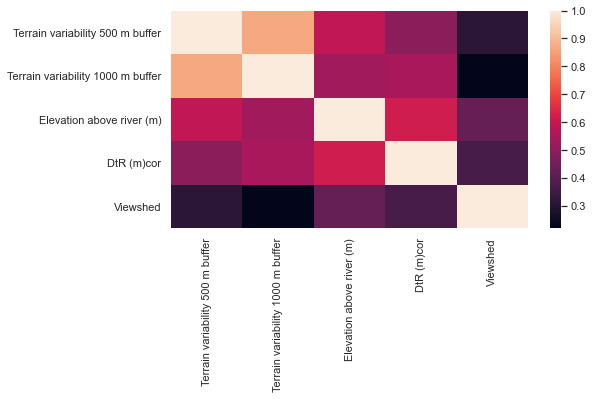

In [43]:
# varible correlation
my_features = [
       'Terrain variability 500 m buffer', 'Terrain variability 1000 m buffer','Elevation above river (m)', 
       'DtR (m)cor', 'Viewshed']
sns.heatmap(preprocess_df[my_features].corr())

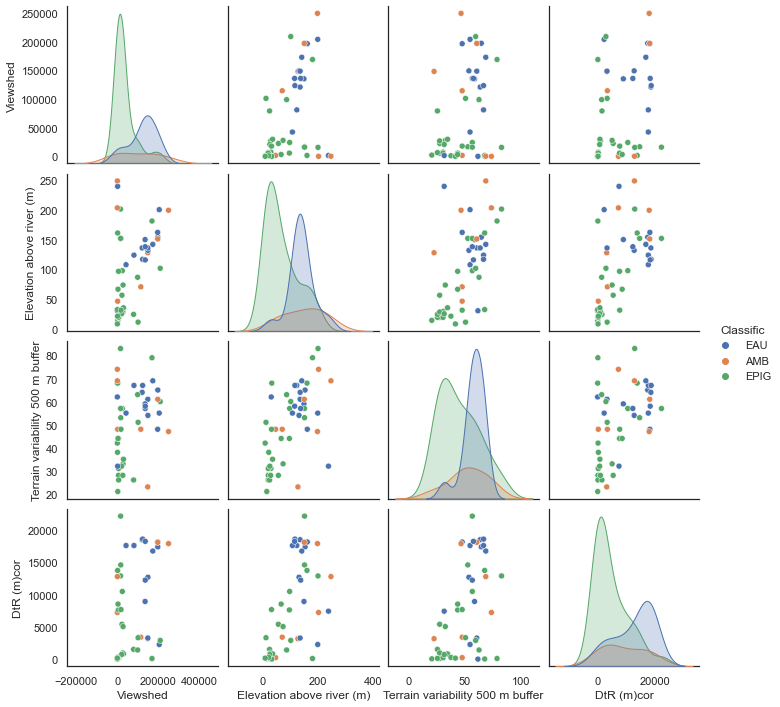

In [91]:
from pylab import savefig
pairplot_table = preprocess_df[['Viewshed','Classific','Elevation above river (m)','Terrain variability 500 m buffer','DtR (m)cor']]
sns.set(style="white")


svm = sns.pairplot(pairplot_table, hue="Classific");
  


### distance to the closest big river based on cultur

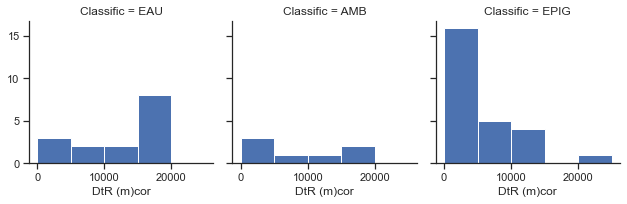

<Figure size 432x288 with 0 Axes>

In [209]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)

x = sns.FacetGrid(preprocess_df_1, col='Classific')
bins= [0,5000,10000,15000,20000,25000]
x.map(plt.hist, 'DtR (m)cor', bins=bins )
plt.show()
plt.tight_layout()


### elevation above river is more important indicator than altitude

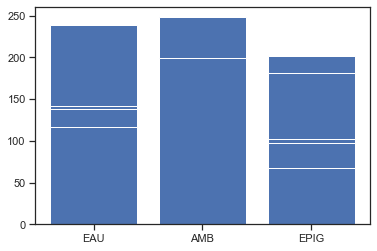

In [216]:
plt.bar(x=preprocess_df_1['Classific'], height=preprocess_df_1['Elevation above river (m)'])
plt.show()

In [53]:
preprocess_df_1.columns

Index(['site', 'LU zone', 'LU Min', 'LU Max', 'LU Range',
       'Terrain variability 500 m buffer', 'Terrain variability 1000 m buffer',
       'Classific', 'Lithics (N)', 'Cores (N)', 'Tools (N)', 'Altitude a.s.l.',
       'Elevation above river (m)', 'Relative hight in LUmin (%)',
       'DtR (m)cor', 'DtR (d2)', 'EAR2+DtR2', 'orientation', 'Viewshed',
       'Normalized height in Lu Min'],
      dtype='object')

#### we can clearly see that EAU are situated further from the river at the higher possition close to the top of the hills (Viewshed)

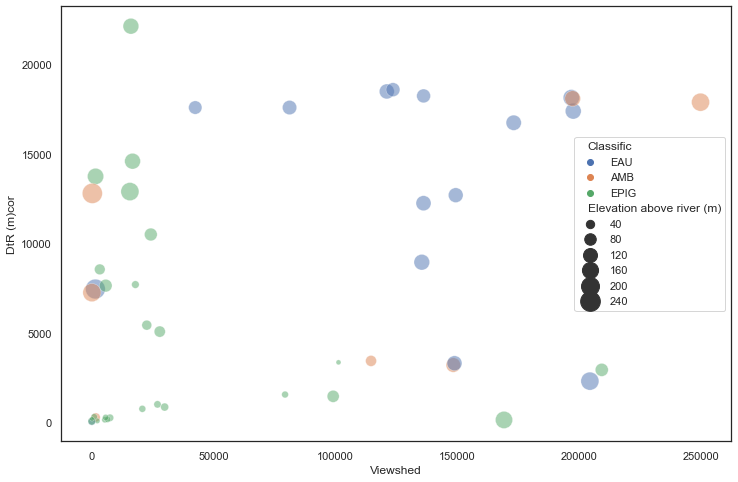

In [56]:
fig = plt.figure(figsize=(12,8))
sns.scatterplot(data=preprocess_df_1, x="Viewshed", y="DtR (m)cor", size="Elevation above river (m)", hue="Classific", alpha=0.5, sizes=(20, 400))

plt.show()

### grouping - based on cultural affiliation

In [196]:
#grouping based on cultural affiliation

tmp1 = preprocess_df_1.groupby(['Classific'],\
                    as_index = False).mean().sort_values(by='Elevation above river (m)', ascending=False)

tmp1

,Classific,LU Min,LU Max,LU Range,Terrain variability 500 m buffer,Terrain variability 1000 m buffer,Lithics (N),Cores (N),Tools (N),Elevation above river (m),Relative hight in LUmin (%),DtR (m)cor,DtR (d2),EAR2+DtR2,Viewshed,Normalized height in Lu Min
0,AMB,195.857143,718.857143,523.000000,52.857143,98.000000,1438.857143,56.285714,327.857143,149.571429,28.346819,8992.857143,1.266429e+08,1.266699e+08,101759.428571,0.283468
1,EAU,190.333333,689.266667,498.933333,58.200000,121.133333,1255.466667,61.266667,252.466667,139.000000,29.021149,12656.000000,2.011118e+08,2.011330e+08,123184.000000,0.290211
2,EPIG,192.961538,627.461538,434.500000,45.153846,89.384615,672.076923,13.653846,47.153846,67.615385,16.948831,4682.692308,5.547646e+07,5.548431e+07,35363.807692,0.169488


In [46]:
#group based on regions

tmp2 = preprocess_df_1.groupby(['LU zone'],\
                    as_index = False).mean().sort_values(by='Elevation above river (m)', ascending=False)
tmp2.round(1)


,LU zone,LU Min,LU Max,LU Range,Terrain variability 500 m buffer,Terrain variability 1000 m buffer,Lithics (N),Cores (N),Tools (N),Elevation above river (m),Relative hight in LUmin (%),DtR (m)cor,DtR (d2),EAR2+DtR2,Viewshed,Normalized height in Lu Min
10,Odra_S,212.0,1250.0,1038.0,69.0,132.0,9.0,0.0,8.0,248.0,23.9,12800.0,163840000.0,163901504.0,427.0,0.2
8,MKras,261.0,748.0,487.0,53.0,85.0,537.5,22.5,84.5,221.0,45.4,7350.0,54032500.0,54081665.0,971.0,0.5
13,Oslava_SW,220.0,490.0,270.0,79.0,131.0,966.0,34.0,152.0,181.0,67.0,130.0,16900.0,49661.0,169096.0,0.7
5,Litava_N,169.0,587.0,418.0,56.8,123.4,55.2,4.8,4.6,148.0,35.4,10990.0,137824500.0,137847582.8,41439.8,0.4
7,MHana_S,180.0,585.0,405.0,60.0,114.5,1192.5,133.0,350.0,143.0,35.3,6125.0,45496250.0,45516748.0,142118.5,0.4
6,MHana_N,178.0,744.0,566.0,59.2,121.5,1772.4,71.2,376.3,140.8,24.9,17380.8,307964038.5,307984406.1,140032.5,0.2
3,Jihlava_SW,160.0,421.0,261.0,44.0,102.0,58.0,5.0,5.0,97.0,37.2,7640.0,58369600.0,58379009.0,5917.0,0.4
14,Svitava E,183.0,472.0,289.0,48.0,70.0,144.0,11.0,21.0,71.0,24.6,3430.0,11764900.0,11769941.0,114620.0,0.2
9,Morava_E,158.0,961.0,803.0,50.2,99.6,234.4,7.8,42.2,68.4,8.5,4270.0,24143460.0,24149076.4,88218.8,0.1
16,Svratka_S,165.0,468.0,303.0,28.0,42.0,8.0,0.0,0.0,57.0,18.8,5430.0,29484900.0,29488149.0,22734.0,0.2


<div style="background-color: orange; height:150px; width: 100%; display: inline-block; text-align:center;">
    <h1>preprocessing - removing irrelavant or redundant or duplicite columns</h1>
    <h1>delete ambiguous records and create dummy variables for target and orientation </h1>
</div>


# 1. why we are deleting some columns ?
####   1. - we do not need site names - it's just a site name for archaeological purposes
####   2. - LU zone - zones are too small to assign any huge importance to them
####   3.,4.,5. - LU Min, LU Max, LU range - related to LU zone
####   9.,10.,11. - related to number of tools etc. this is quite irrelevant for the purpose of the model and also the number of artefacts is affected by the extension of archaeological excavation
####   16.,17. DtR(d2)(only squared DtrR)  and EAR2+DtR2- are nearly duplicated value 
####   14., 20., Relative hight in LUmin (%) and Normalized height in Lu Min - only normalized value

# 2 .removing ambiguous (amb) records - as we cannot describe which culture it's associated with

In [35]:
preprocess_df_1.head()

,site,LU zone,LU Min,LU Max,LU Range,Terrain variability 500 m buffer,Terrain variability 1000 m buffer,Classific,Lithics (N),Cores (N),Tools (N),Altitude a.s.l.,Elevation above river (m),Relative hight in LUmin (%),DtR (m)cor,DtR (d2),EAR2+DtR2,orientation,Viewshed,Normalized height in Lu Min
0,Alojzov I - Golštýn,MHana_N,178,744,566,65,136,EAU,8015,305,1879,332,154,27.208481,17400,302760000,302783716,NE,197464,0.272085
1,Blažovice I,Litava_N,169,587,418,23,43,AMB,75,6,15,297,128,30.622010,3200,10240000,10256384,top,148319,0.306220
2,Bratčice,Svratka_S,165,468,303,28,42,EPIG,8,0,0,220,57,18.811881,5430,29484900,29488149,N,22734,0.188119
3,Brno - Jundrov,Svratka_N,190,487,297,48,127,AMB,335,14,60,238,47,15.824916,270,72900,75109,SE,1834,0.158249
4,Brno - Kohoutovice I,Svratka_N,190,487,297,55,127,EAU,915,43,200,390,200,67.340067,2300,5290000,5330000,top,204292,0.673401


In [36]:
indices = np.arange(1, len(preprocess_df_1.columns) + 1)
columns_table = pd.DataFrame(preprocess_df_1.columns, index=indices, columns=["attributes"]).T
columns_table

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
attributes,site,LU zone,LU Min,LU Max,LU Range,Terrain variability 500 m buffer,Terrain variability 1000 m buffer,Classific,Lithics (N),Cores (N),Tools (N),Altitude a.s.l.,Elevation above river (m),Relative hight in LUmin (%),DtR (m)cor,DtR (d2),EAR2+DtR2,orientation,Viewshed,Normalized height in Lu Min


In [37]:
# picking only relevant columns
preprocessed_table_final = preprocess_df_1[[
       'Terrain variability 500 m buffer', 'Terrain variability 1000 m buffer','Elevation above river (m)', 
       'DtR (m)cor', 'orientation', 'Viewshed', 'Classific']]

In [38]:
# removing ambiguous records
preprocessed_table_final = preprocessed_table_final[(preprocessed_table_final['Classific'] == 'EAU') | (preprocessed_table_final['Classific'] == 'EPIG')]

### create dummy variables for orientation and classification (eau == 0, epig == 1)

In [39]:
def create_dummy_culture(culture):
    """
    EAU = 0
    EPIG = 1
    """
    if culture == 'EAU':
        return 0
    else:
        return 1

preprocessed_table_final['Classific'] = preprocessed_table_final['Classific'].apply(create_dummy_culture)

In [40]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder(dtype=int)
preprocessed_table_final['orientation'] = ord_enc.fit_transform(preprocessed_table_final[['orientation']])

In [41]:
preprocessed_table_final.head()

,Terrain variability 500 m buffer,Terrain variability 1000 m buffer,Elevation above river (m),DtR (m)cor,orientation,Viewshed,Classific
0,65,136,154,17400,2,197464,0
2,28,42,57,5430,1,22734,1
4,55,127,200,2300,9,204292,0
6,31,68,30,250,2,7675,1
7,21,72,15,80,0,2460,1


### final preprocessed table

In [273]:
preprocessed_table_final.to_csv('preprocessed_final_table.csv', index=False)